Set colab to access the images in Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model

Import the required libraries

In [ ]:
!pip install tensorflow

In [ ]:
import os   # To navigate into the drive folders and access the images
import matplotlib.pyplot as plt   # To make plots
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator  # To process images in batches and apply transformations
from keras.applications import VGG19   # Import the VGG19 model
from keras.models import Sequential    # Allow us to add another layer to the pretrained model that makes the classification
from keras.layers import Flatten, Dense, Dropout   # Flatten the output layer to make it able for input in the Dense layer
from keras.optimizers import Adam    # Import the Adam optimizer


Defining paths to our images

In [ ]:
# Define the base directory where your 'sample' folder is located
base_dir = '/content/drive/My Drive/Sample'

# Define the paths to the training, validation, and testing directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

Data normalization and ImageDataGenerator instances

In [ ]:
# Rescale the pixel values from [0, 255] to [0, 1] for normalization

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=32,  # It will be iterating from batches of 20 images
    class_mode= 'binary'  # Label the images in a binary way (Fake or Real)
)

Validation_generator = validation_datagen .flow_from_directory(
    validation_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=32,  # It will be iterating from batches of 20 images
    class_mode= 'binary'  # Label the images in a binary way (Fake or Real)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=20,  # It will be iterating from batches of 20 images
    class_mode= 'binary',  # Label the images in a binary way (Fake or Real)
    shuffle=False)  # No need to shuffle the test data

Found 2798 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
# Load the VGG19 model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model and add the VGG19 base model without dropout
model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu'),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.2),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid')  # Add the output layer with sigmoid activation for binary classification
])


In [ ]:
# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-4),
               loss='binary_crossentropy',
               metrics=['accuracy'])

First model training

In [ ]:
# Model training
num_epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch= 40,
    epochs=num_epochs,
    validation_data=Validation_generator,
    validation_steps = 5
)

Epoch 1/10
40/40 [==============================] - 447s 11s/step - loss: 0.6159 - accuracy: 0.6650 - val_loss: 0.5263 - val_accuracy: 0.7900
Epoch 2/10
40/40 [==============================] - 61s 2s/step - loss: 0.3647 - accuracy: 0.8562 - val_loss: 0.3627 - val_accuracy: 0.8600
Epoch 3/10
40/40 [==============================] - 34s 851ms/step - loss: 0.2506 - accuracy: 0.9212 - val_loss: 0.3752 - val_accuracy: 0.8500
Epoch 4/10
40/40 [==============================] - 27s 675ms/step - loss: 0.1891 - accuracy: 0.9488 - val_loss: 0.3955 - val_accuracy: 0.8200
Epoch 5/10
40/40 [==============================] - 25s 622ms/step - loss: 0.1706 - accuracy: 0.9538 - val_loss: 0.3630 - val_accuracy: 0.8400
Epoch 6/10
40/40 [==============================] - 21s 528ms/step - loss: 0.1118 - accuracy: 0.9812 - val_loss: 0.4015 - val_accuracy: 0.8200
Epoch 7/10
40/40 [==============================] - 24s 590ms/step - loss: 0.0891 - accuracy: 0.9937 - val_loss: 0.3675 - val_accuracy: 0.8300
Epo

## Normalization

Here there is another try including early stopping and normalization


In [ ]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Load the VGG19 model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.2),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch= 40,   # Batch size is 20, 20 times 40 is 800, the size of the training data
    epochs=num_epochs,
    validation_data=Validation_generator,
    validation_steps = 5,
    callbacks=[early_stopping]
)

Epoch 1/20
40/40 [==============================] - 23s 534ms/step - loss: 3.4929 - accuracy: 0.6350 - val_loss: 1.6430 - val_accuracy: 0.7000
Epoch 2/20
40/40 [==============================] - 20s 507ms/step - loss: 1.1184 - accuracy: 0.8313 - val_loss: 1.0748 - val_accuracy: 0.7400
Epoch 3/20
40/40 [==============================] - 21s 519ms/step - loss: 0.6977 - accuracy: 0.9237 - val_loss: 0.9045 - val_accuracy: 0.7200
Epoch 4/20
40/40 [==============================] - 21s 524ms/step - loss: 0.5310 - accuracy: 0.9450 - val_loss: 0.6048 - val_accuracy: 0.8800
Epoch 5/20
40/40 [==============================] - 21s 512ms/step - loss: 0.4317 - accuracy: 0.9638 - val_loss: 0.5679 - val_accuracy: 0.8400
Epoch 6/20
40/40 [==============================] - 22s 558ms/step - loss: 0.3762 - accuracy: 0.9613 - val_loss: 0.5642 - val_accuracy: 0.8500
Epoch 7/20
40/40 [==============================] - 21s 536ms/step - loss: 0.3594 - accuracy: 0.9538 - val_loss: 0.5607 - val_accuracy: 0.8500

# Bigger sample (4000 images)

To reduce the overfitting we are runing the model with bigger sample and see the performance, redefining the model to take the sample from the root folders of real and fake images. Early stopping and L2 regularization is going to be used to avoid voerfitting


In [ ]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint


# Load the VGG19 model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.2),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_path = '/content/drive/My Drive/checkpoints/VGG19/e40_5/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)


history = model.fit(
    train_generator,
    steps_per_epoch= 40,
    epochs=num_epochs,
    validation_data=Validation_generator,
    validation_steps = 5,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 1.4348 - accuracy: 0.6506
Epoch 1: saving model to /content/drive/My Drive/checkpoints/VGG19/e40_5/model_epoch_01_val_accuracy_0.6875.h5
40/40 [==============================] - 11s 252ms/step - loss: 1.4348 - accuracy: 0.6506 - val_loss: 0.8791 - val_accuracy: 0.6875
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7932
Epoch 2: saving model to /content/drive/My Drive/checkpoints/VGG19/e40_5/model_epoch_02_val_accuracy_0.7563.h5
40/40 [==============================] - 10s 251ms/step - loss: 0.6746 - accuracy: 0.7932 - val_loss: 0.6751 - val_accuracy: 0.7563
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.5958 - accuracy: 0.8008
Epoch 3: saving model to /content/drive/My Drive/checkpoints/VGG19/e40_5/model_epoch_03_val_accuracy_0.7688.h5
40/40 [==============================] - 10s 247ms/step - loss: 0.5958 - accuracy: 0.8008 - val_loss: 0.6597 - val_accura

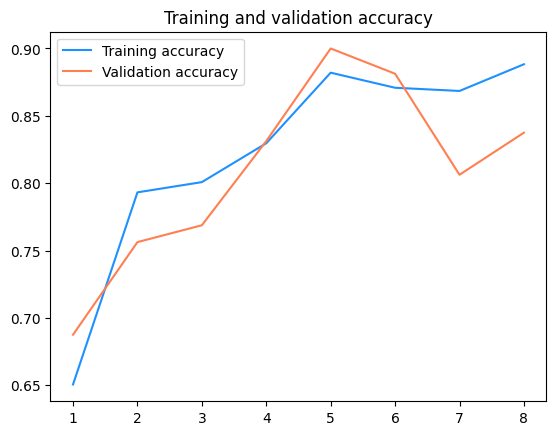

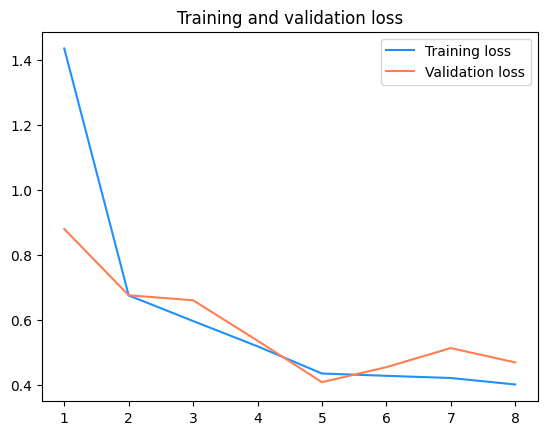

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Now I am setting the steps per epoch to run over the entire dataset, restincting more the training with more dropout and lambda value in regularization

In [ ]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint


# Load the VGG19 model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.3),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training
num_epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_path = '/content/drive/My Drive/checkpoints/VGG19/e88_26/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)


history = model.fit(
    train_generator,
    steps_per_epoch= 88,
    epochs=num_epochs,
    validation_data=Validation_generator,
    validation_steps = 26,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
88/88 [==============================] - ETA: 0s - loss: 2.2738 - accuracy: 0.6698
Epoch 1: saving model to /content/drive/My Drive/checkpoints/VGG19/e88_26/model_epoch_01_val_accuracy_0.8080.h5
88/88 [==============================] - 25s 268ms/step - loss: 2.2738 - accuracy: 0.6698 - val_loss: 0.9198 - val_accuracy: 0.8080
Epoch 2/15
88/88 [==============================] - ETA: 0s - loss: 0.7708 - accuracy: 0.7902
Epoch 2: saving model to /content/drive/My Drive/checkpoints/VGG19/e88_26/model_epoch_02_val_accuracy_0.8254.h5
88/88 [==============================] - 23s 259ms/step - loss: 0.7708 - accuracy: 0.7902 - val_loss: 0.6400 - val_accuracy: 0.8254
Epoch 3/15
88/88 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.8059
Epoch 3: saving model to /content/drive/My Drive/checkpoints/VGG19/e88_26/model_epoch_03_val_accuracy_0.8429.h5
88/88 [==============================] - 23s 261ms/step - loss: 0.6173 - accuracy: 0.8059 - val_loss: 0.5683 - val_acc

In [ ]:
# Evaluate the model's performance on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 8s 147ms/step - loss: 0.4775 - accuracy: 0.8475
Test accuracy: 0.8475000262260437


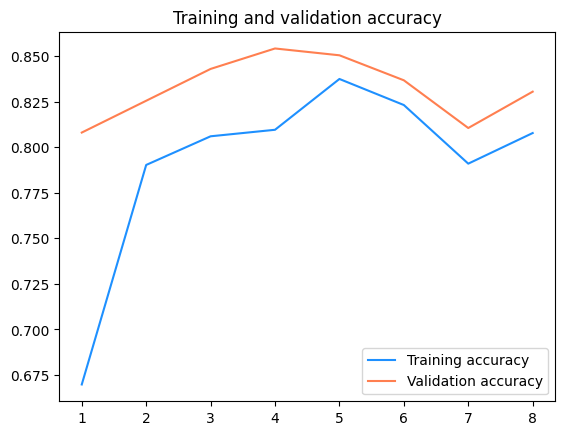

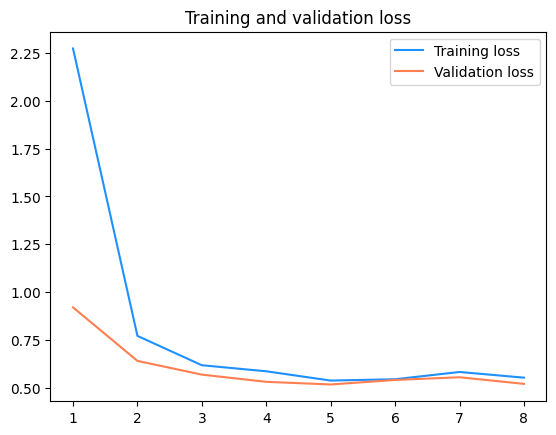

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Now we are going to taste some models:

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/VGG19/e88_26/model_epoch_06_val_accuracy_0.8367.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')


Found 400 files belonging to 2 classes.
13/13 [==============================] - 2s 162ms/step - loss: 0.5438 - accuracy: 0.8550
Test loss: 0.5438, Test accuracy: 0.8550
